In [80]:
!pip install --break-system-packages tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
  Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.9 MB)


In [1]:
# Import standard dependencies
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Input, Flatten
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
# Import uuid library to generate unique image names
import uuid
# Import custom class and functions
from utils import L1Dist, cut_frame, preprocess_file

2024-09-06 17:43:24.902709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 17:43:26.291740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus) # None on Mac lmao
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[]


2024-09-01 00:28:28.782202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-01 00:28:28.807636: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [207]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset # https://vis-www.cs.umass.edu/lfw/
!tar -xf lfw.tgz

In [208]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [3]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = cut_frame(frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    key = cv2.waitKey(1) & 0XFF
    match key:
        # Collect anchors on q
        case 97:
            # Create the unique file path 
            imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            # Write out anchor image
            cv2.imwrite(imgname, frame)
        # Collect positives on p
        case 112:
            # Create the unique file path 
            imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            # Write out positive image
            cv2.imwrite(imgname, frame)
        # Break gracefully on q
        case 113: break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

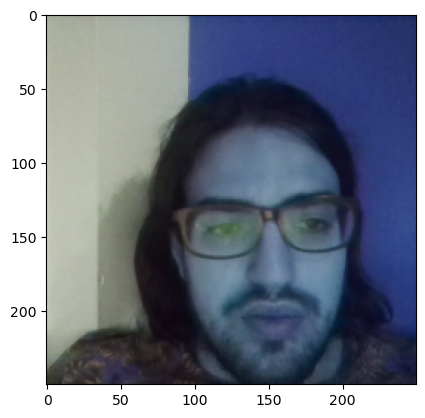

In [10]:
plt.imshow(frame)

In [18]:
def data_aug(img):
    data = []
    for i in range(2):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        # img = tf.image.stateless_random_crop(img, size=(20, 20, 3), seed=(1, 2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))

        data.append(img)

    return data

In [19]:
for DATA_PATH in [POS_PATH, ANC_PATH]:
    for file_name in os.listdir(DATA_PATH):
        img_path = os.path.join(DATA_PATH, file_name)
        augmented_images = data_aug(cv2.imread(img_path)) 

        for image in augmented_images:
            cv2.imwrite(os.path.join(DATA_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

2024-09-02 18:04:43.611286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-02 18:04:43.643160: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(3000)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(3000)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(3000)

In [12]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
raw_data = positives.concatenate(negatives)

In [5]:
samples = raw_data.as_numpy_iterator()
example = samples.next()
example

(b'data/anchor/92fb964c-6790-11ef-82ce-5cc5d47db176.jpg',
 b'data/positive/4970cac6-6793-11ef-82ce-5cc5d47db176.jpg',
 1.0)

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess_file(input_img), preprocess_file(validation_img), label)

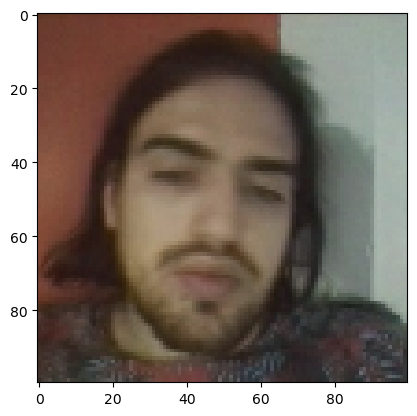

In [7]:
res = preprocess_twin(*example)
plt.imshow(res[1])

In [14]:
# Build dataloader pipeline
data = raw_data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [15]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [16]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [17]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [18]:
embedding = make_embedding()
embedding.summary()

2024-09-03 00:48:09.232821: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-09-03 00:48:09.291386: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-09-03 00:48:09.334284: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [22]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
print(inp_embedding)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_9>]


In [19]:
siamese_layer = L1Dist()

In [23]:
distances = siamese_layer(inp_embedding[0], val_embedding[0])

In [24]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_12>

In [25]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])

    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [27]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [33]:
checkpoint_dir = os.path.join('data', 'training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [227]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

In [231]:
y

array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [30]:
@tf.function
def train_step(batch):
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [31]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object 
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx + 1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [34]:
EPOCHS = 30
train(train_data, EPOCHS)


 Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-09-04 01:26:58.819887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste


2024-09-04 01:46:30.426971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/stept
1/1 

2024-09-04 02:06:07.422849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste


2024-09-04 02:25:46.340472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste

2024-09-04 02:45:15.194194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1

2024-09-04 03:04:38.556796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━

2024-09-04 03:23:55.188286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept


2024-09-04 03:43:03.112200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step

2024-09-04 04:02:32.466913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━

2024-09-04 04:21:50.041409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/s

2024-09-04 04:41:08.991502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/stept

2024-09-04 05:00:29.276926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━

2024-09-04 05:19:41.705454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/ste

2024-09-04 05:39:04.632318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1

2024-09-04 05:58:13.114828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1

2024-09-04 06:17:22.397735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/stept
1/1 ━

2024-09-04 06:36:33.081932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━

2024-09-04 06:55:48.213041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1

2024-09-04 07:15:12.028888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/stept


2024-09-04 07:34:39.214646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2

2024-09-04 07:54:09.275338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━

2024-09-04 08:13:50.403297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━

2024-09-04 08:33:44.230553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━

2024-09-04 08:53:36.128619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━

2024-09-04 09:13:44.129902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/

2024-09-04 09:33:58.081132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/stept


2024-09-04 09:54:11.453852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste

2024-09-04 10:14:35.984741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/stept
1/1 ━━

2024-09-04 10:35:03.505214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/stept
1/1 ━━━━

2024-09-04 10:55:30.942046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
# Save weights
siamese_model.save(os.path.join('data', 'siamesemodelv2.keras'))

In [35]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [36]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]

In [37]:
y_true

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [38]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [39]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [40]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-09-02 14:52:34.140078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
# Make predictions with model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


array([[3.8119946e-10],
       [9.9999911e-01],
       [1.0000000e+00],
       [1.4291573e-10],
       [9.9997479e-01],
       [9.9998647e-01],
       [1.6578869e-09],
       [1.2186389e-08],
       [1.7791180e-09]], dtype=float32)